<a href="https://colab.research.google.com/github/musicjae/cs231n/blob/master/assignment3/RNN_and_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
uploaded = files.upload() # 파일 업로드 기능 실행

for fn in uploaded.keys(): # 업로드된 파일 정보 출력
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

Saving rnn1.png to rnn1.png
User uploaded file "rnn1.png" with length 232500 bytes


In [1]:
from IPython.display import Image

# 1. What is the RNN?  


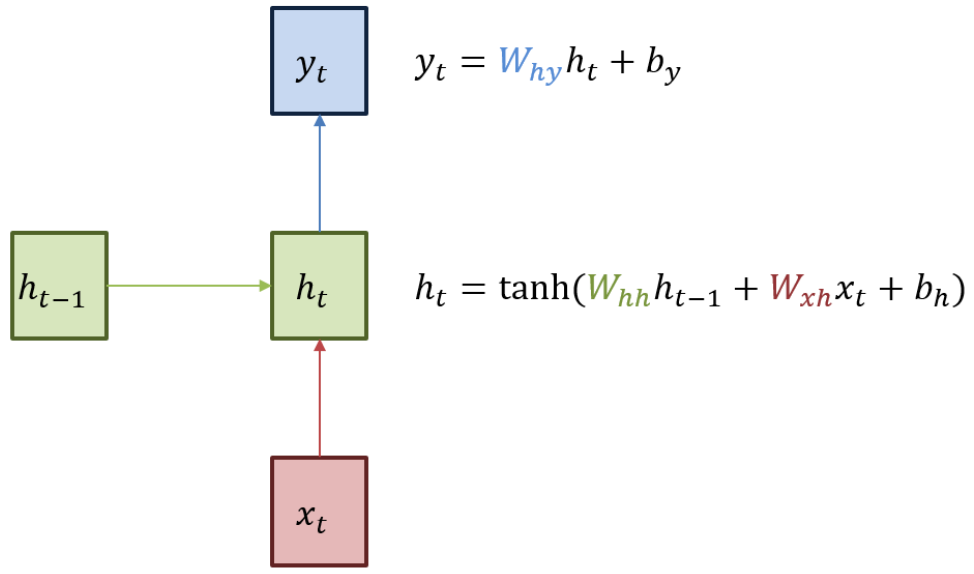

In [ ]:
Image('r1.png',width=600)

## 1.1 RNN의 특징  
- 현 시점에 입력되는 은닉층은 (1) 이전 시점에 입력된 은닉층, (2) 현 시점에 입력되는 입력값을 입력 받는다.  
- 현재의 은닉층은 비선형 함수(활성화 함수)의 적용을 받는다. 이것은 단순히 선형적 함수로만 합성된 것, 가령 $y=f(g(h(x)))$일 때, $f(x)=2x, g(x)=3x, h(x) = 2x+1$인 경우에, y는 사실 $2(3(2x+1))$과 다름 없기에, 즉 $y=12x+6$이기에 다시 선형 함수 밖에 안된다. 따라서 이것은 기존의 첫 입력값인 $h(x)$와 비교할 때 **또 다른 층을 쌓았다고 볼 수 없다.** 이러한 탓에 만약 우리가 또 다른 층을 쌓고자 한다면, **비선형 함수**를 활성화 함수로 사용해야 한다.  

- 출력값인 y는 현 시점에 입력되는 은닉층에 비선형 함수를 적용한 값이다.


## 1.2 구체적 사례  
  


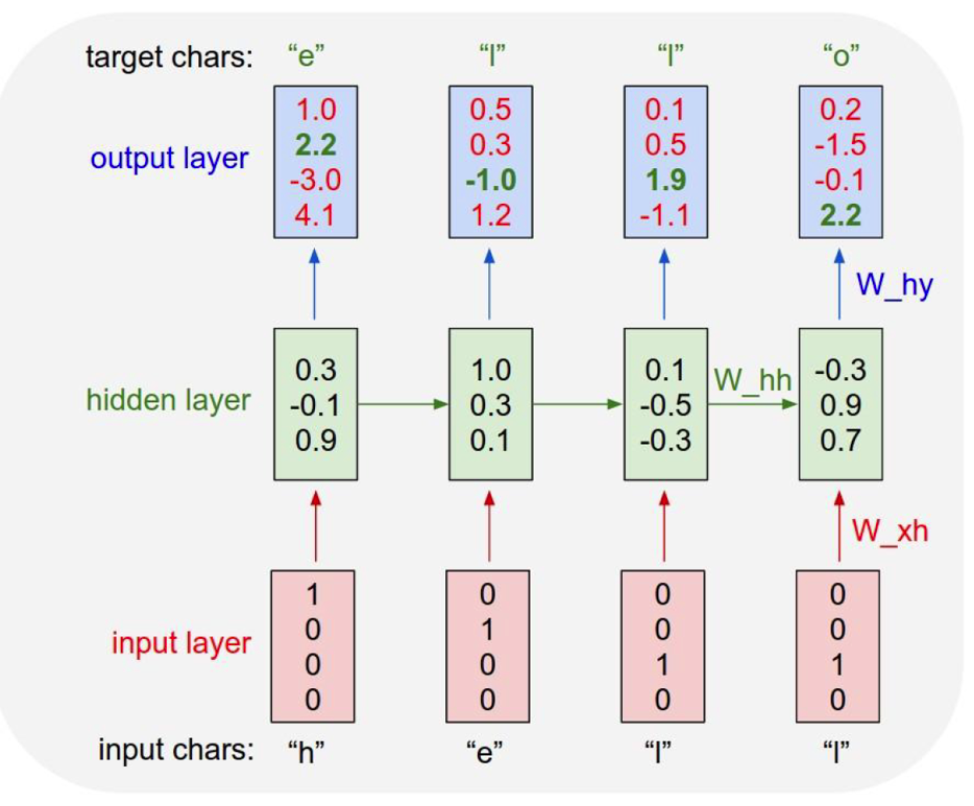

In [ ]:
Image('r2.png',width=600)

RNN을 더 자세히 이해하기 위해 cs231n에서 제공된 예를 보자.  
  
- 목적: 'hell' 입력 --> 'o'를 예측하여 'hello'를 출력  
  - (1) 'hell' 4 개의 words를 고려하여, one-hot-encodeing 방식으로  
   $\begin{bmatrix} h\\e\\l\\l \end{bmatrix}$ $=$$\begin{bmatrix} 1&0&0&0\\0&1&0&0\\0&0&1&0\\0&0&0&1\end{bmatrix}$  
   라고 둔다.  
 - (2) $x1$만을 고려할 때, $h1$은 다음의 입력을 받는다: (1) $\begin{bmatrix} 1&0&0&0\end{bmatrix}$과, (2) (처음 은닉층이니까) random 값인 $Matrix{(1,4)}$.  
 - (3) $h_1$이 $\begin{bmatrix} 0.3&-0.1&0.9\end{bmatrix}$임을 고려할 때, $W$의 크기는 $W_{(4,3)}$이다.

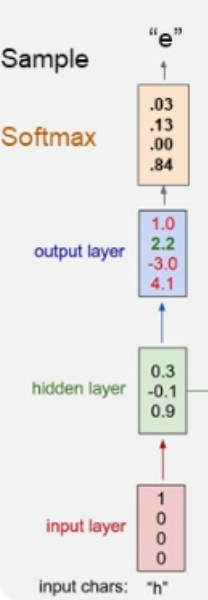

In [ ]:
Image('r4.png',width=150)

-  - (4) 은닉층에서 출력층으로 계산한 뒤, 소프트맥스로 다음에 나올 예상 값을 계산한다. 위 계산에 따르면, 'h'입력 뒤에 나올 단어는 $0.84$의 값에 상응하는 'l'일 것이다. 하지만 원래 나와야 할 정답 값은 'e'이다. 즉 위의 경우 (첫 epoch에서의 Forward pass 계산)는 잘못된 다음 글자를 예측하고 있다. 이것은 높은 loss 값을 가질 것임을 함의한다. (하지만 종국에 많은 학습이 달성되어, loss가 낮아지면 정확한 예측을 할 것이다.)  
 - (5) 이러한 방식으로 제대로 학습된 알고리즘은 'hell'의 입력으로부터 'hello'를 출력할 것이다.

## 1.3 RNN의 장단점  
  
- 장점 
> - 각 샘플이 이전 값들에 의존한다고 가정될 수 있는 **시퀀스** 데이터를 모델링할 수 있다  
  - one-to-one이 아닌 many-to-many, m2o, o2m 등의 구조 사용 (시퀀스 처리 용이), 고정적 길이 뿐만 아니라, 가변적 길이의 데이터 처리에도 용이)  
  - 가중치 공유 (메모리 효율적)

  
- 단점  
> - gradient vanishing & exploding  
  - RNN 훈련은 매우 어려운 작업  
  - 활성화 함수로서 tanh, relu 사용 시, 매우 긴 시퀀스를 처리할 수 없다

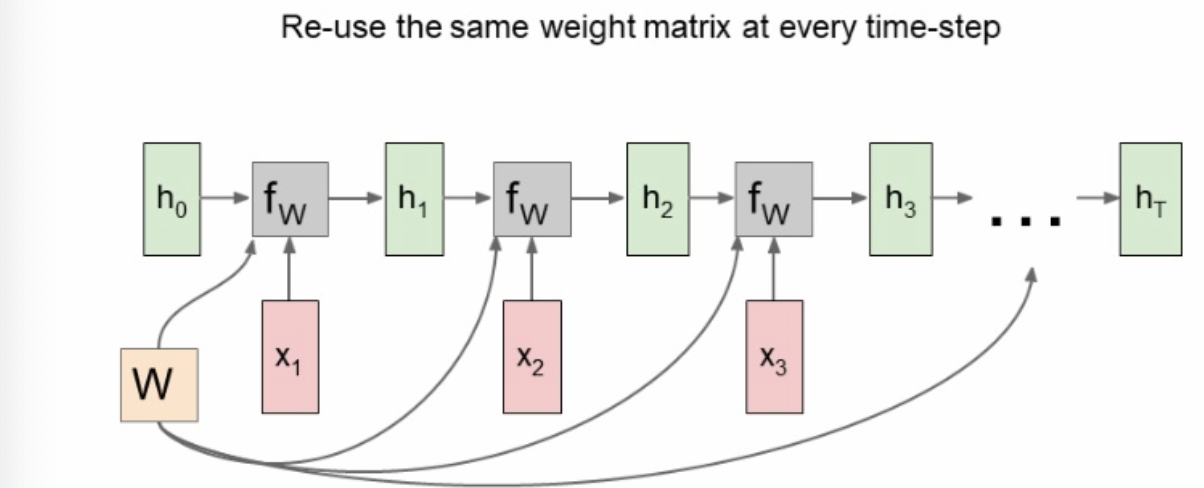

In [ ]:
Image('r3.png',width=600)

## 1.4 RNN Implementation

### 1.4.1 Vanila RNN

Shape  
  
- $h_{t-1}$: N,H  
- $W_h$: H,H  
- $x_t$:N,D  
- $W_x$:D,H  
- $h_t$:N,H

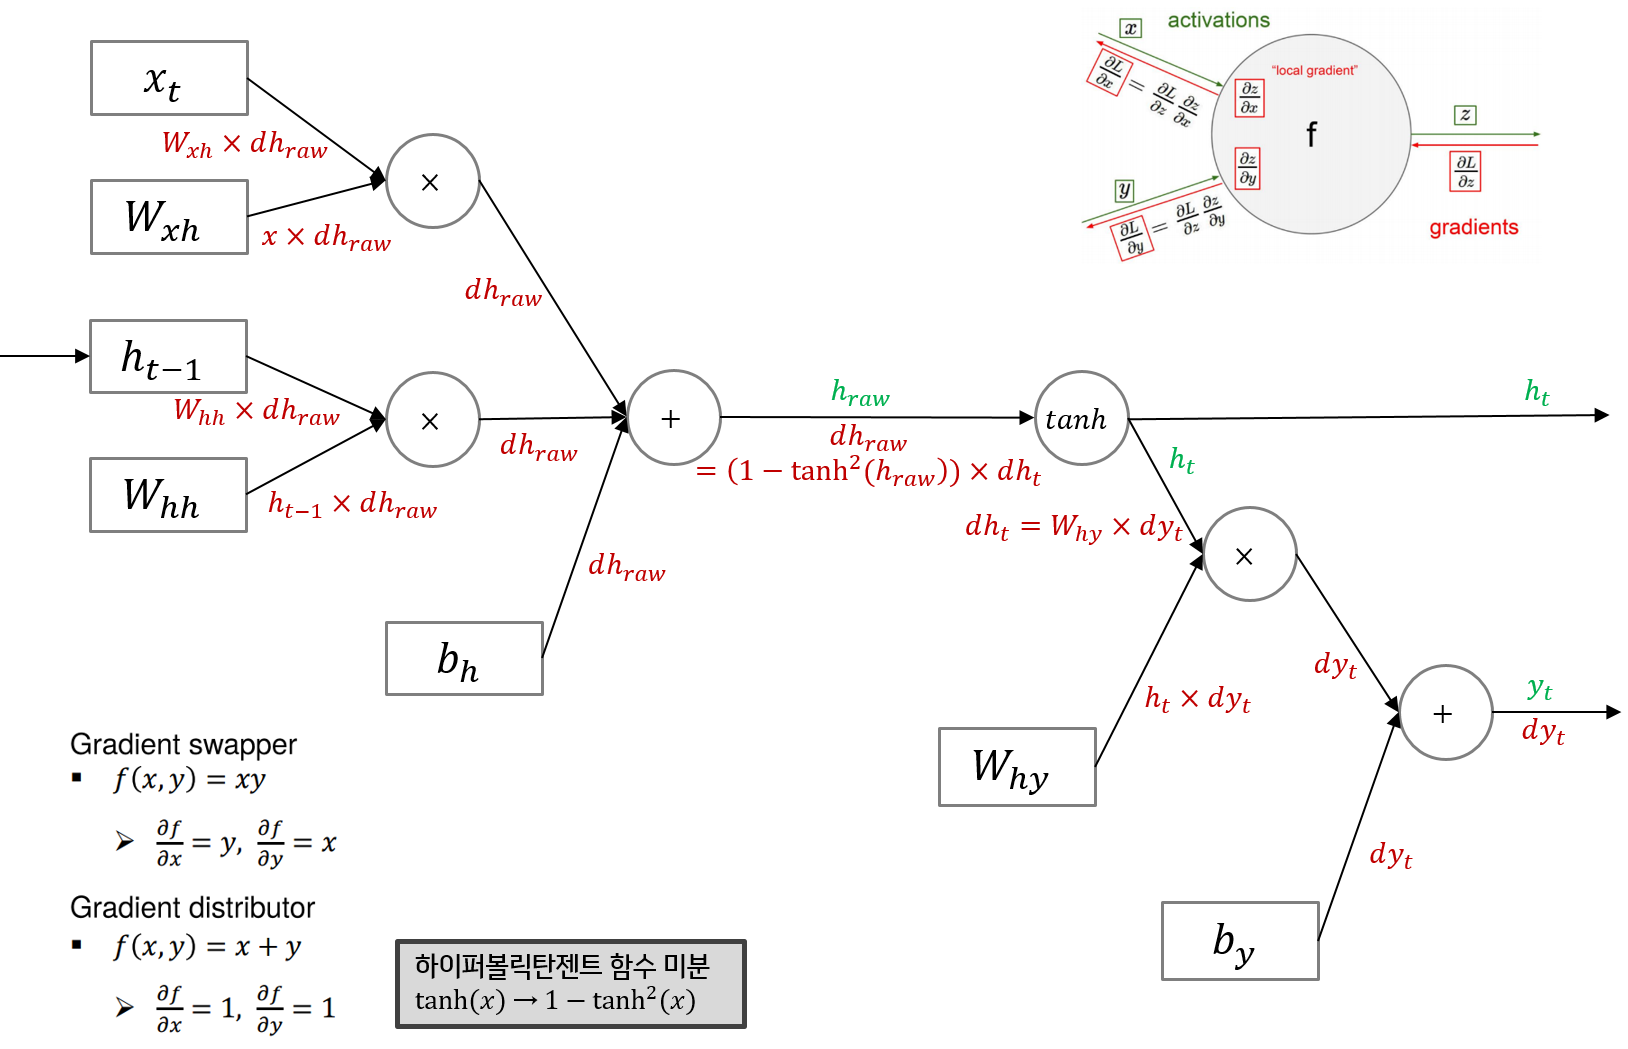

In [4]:
Image('rnn1.png',width=800)

우리는 현 시점에서 위 그래프의 $h_t$까지만 고려한다.

In [ ]:
import numpy as np

class RNN:

    def __init__(self, Wx, Wh, b):

        self.params = [Wx,Wh,b]
        self.grads = [np.zero_like(Wx), np.zero_like(Wh),np.zero_like(b)]
        self.cache=None

    def forward(self, x, h_prev):

        Wx, Wh, b = self.params
        h_raw = np.dot(Wx, x.T)+ np.dot(h_prev,Wh)+b
        h_next = np.tanh(h_raw)

        self.cache = [x, h_prev, h_next] # Update the cache and transfer it backward function

        return h_next

    def backward(self, dh_next):

        Wx, Wh, b = self.params
        x,h_prev,h_next = self.cache

        dh_raw = dh_next*(1-h_next**2)
        db = np.sum(dh_raw, axis = 0)
        dx = np.dot(dh_raw, Wx.T)
        dWx = np.dot(x.T, dh_raw)
        dh_prev = np.dot(dh_raw,Wh)
        dWh = np.dot(h_prev.T, dh_raw)

        self.grads = dWx, dWh, db

        return dx, dh_prev


### 1.4.2 Time RNN

시계열 데이터를 다루는 RNN

In [ ]:
class TimeRNN:

    def __init__(self, Wx, Wh, b, stateful=False):

        self.grads = [np.zero_like(Wx),np.zero_like(Wh),np.zero_like(b)]
        self.params = [Wx, Wh, b]
        self.layers = None

        self.h, self.dh = None, None
        self.stateful = stateful # It takes stateful values as the Boolean (T/F). It plays a role to store a various of RNN layers as the list form.
                                 # stateful is True --> RNN layers keep hidden states. Otherwise, initailize the states as zero matrix.
    def set_state(self, h):
        self.h = h

    def reset_state(self,h):
        self.h = None

    def forward(self, xs): # xs is the one data that unites a series of data with the length T.

        Wx, Wh,b= self.params
        N,T,D = xs.shape # N: # mini batch, 
                         # T: # Time 
                         # D: Dimentionality of input
                         
        D,H = Wx.shape # H: # hidden layers

        self.layers=[]
        hs = np.empty((N,T,H), dtype='f') # Union of a series of hidden layer

        if not self.stateful or self.h is None:
            self.h = np.zeros((N,H),dtype='f') # Reset RNN layers as zero

        for time in range(T): # iterate for T

            layer = RNN(*self.params) # '*' transfers elements extracted in the list to arguments in a method.
                                      # Remind the layer has list form
            self.h = layer.forward(xs[:,t,:],self.h) # For each time, update forward output. self.h refers to h_prev
            hs = [:,t,:] = self.h # For each time, update h
            self.layers.append(layer)

        return hs # return one union of hidden layers

    def backward(self, dhs):

        Wx, Wh,b= self.params
        N,T,D = xs.shape 
        D,H = Wx.shape 
        # init
        dxs = np.empty((N,T,D),dtype='f')
        dh=0
        grads=[0,0,0]

        for time in reversed(range(T)):

            layer = self.layers[time] # the layer that "i need" is in layers list at "specific" time
            dx, dh = layer.backward(dhs[:,t,:]+dh) # Update the grad. Notice that dhs is d_time for all time values, and dh is dh_next.
            dxs[:,t,:] = dx # update dxs that i'll return

            for i, grad in enumerate(layer.grads):
                grads[i] += grad # update grads by summing each 'grad'


        for i,grad in enumerate(grads):

            self.grads[i] = grad # Final grad is the sum of all previous grads.
        self.dh = dh

            return dxs 

        




In [21]:
import numpy as np
Wx = np.arange(4).reshape(2,2)
Wh = np.arange(6).reshape(2,3)
b = np.arange(6).reshape(3,2)
print('Wx:',Wx,'\n\nWh:',Wh,'\n\nb:',b,'\n\n\n')
grads = [Wx,Wh,b]
for i,grad in enumerate(grads):
    grads[i] += grad
    print(i,'th\n:', grad,'\n\ngrads[i]',grads[i],'\n\n\n')

print('\n\n\n\n',grad)

Wx: [[0 1]
 [2 3]] 

Wh: [[0 1 2]
 [3 4 5]] 

b: [[0 1]
 [2 3]
 [4 5]] 



0 th
: [[0 2]
 [4 6]] 

grads[i] [[0 2]
 [4 6]] 



1 th
: [[ 0  2  4]
 [ 6  8 10]] 

grads[i] [[ 0  2  4]
 [ 6  8 10]] 



2 th
: [[ 0  2]
 [ 4  6]
 [ 8 10]] 

grads[i] [[ 0  2]
 [ 4  6]
 [ 8 10]] 







 [[ 0  2]
 [ 4  6]
 [ 8 10]]


# References  
[1] http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture10.pdf  
[2] https://towardsdatascience.com/understanding-rnn-and-lstm-f7cdf6dfc14e  
[3] https://github.com/Intelligence-Engineering-LAB-KU/Seminar/blob/master/summer_2020/0825_ysj_RNN_theory_and_LSTM.ipynb